## **Topic Modeling**

There are several existing algorithms you can use to perform topic modeling. The most common are Latent Semantic Analysis (LSA/LSI), Probabilistic Latent Semantic Analysis (pLSA), and Latent Dirichlet Allocation (LDA).

### **Step 1: Loading Data**

We use the dataset of papers published in NeurIPS (NIPS) conference which is one of the most prestigious yearly events in the machine learning community. The CSV data file contains information on the different NeurIPS papers that were published from 1987 until 2016.

In [4]:
import zipfile
import pandas as pd
import os

# Open the zip file
with zipfile.ZipFile("5_NIPS Papers.zip") as zip_ref:
    # Extract the file to a temporary directory
    zip_ref.extractall("temp")

# Read the CSV file into a pandas DataFrame
papers = pd.read_csv("5_NIPS Papers/papers.csv")

# Print head
papers.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


### **Step 2: Data cleaning**

Since the goal of this analysis is to perform topic modeling, let's focus only on the text data from each paper, and drop other metadata columns. Also, for the demonstration, we'll only look at 100 papers.

In [5]:
# Remove the columns
papers = papers.drop(columns=['id', 'event_type', 'pdf_name'], axis=1).sample(100)

# Print out the first rows of papers
papers.head()

,year,title,abstract,paper_text
4546,2013,Sketching Structured Matrices for Faster Nonli...,Motivated by the desire to extend fast randomi...,Sketching Structured Matrices for\nFaster Nonl...
6416,1993,Two-Dimensional Object Localization by Coarse-...,Abstract Missing,Two-Dimensional Object Localization by\nCoarse...
4593,2013,Near-optimal Anomaly Detection in Graphs using...,The detection of anomalous activity in graphs ...,Near-optimal Anomaly Detection in Graphs\nusin...
3784,2011,Structural equations and divisive normalizatio...,Components estimated by independent component ...,Structural equations and divisive normalizatio...
2956,1990,A four neuron circuit accounts for change sens...,Abstract Missing,A four neuron circuit accounts for change sens...


**Remove punctuation/lower casing**

Let’s perform a simple preprocessing on the content of paper_text column to make them more amenable for analysis, and reliable results. To do that, we’ll use a regular expression to remove any punctuation, and then lowercase the text.

In [6]:
# Load the regular expression library
import re

# Remove punctuation
papers['paper_text_processed'] = \
papers['paper_text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
papers['paper_text_processed'] = \
papers['paper_text_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
papers['paper_text_processed'].head()

4546    sketching structured matrices for\nfaster nonl...
6416    two-dimensional object localization by\ncoarse...
4593    near-optimal anomaly detection in graphs\nusin...
3784    structural equations and divisive normalizatio...
2956    a four neuron circuit accounts for change sens...
Name: paper_text_processed, dtype: object

### **Step 3: Exploratory analysis**

To verify whether the preprocessing, we’ll make a simple word cloud using the wordcloud package to get a visual representation of most common words. It is key to understanding the data and ensuring we are on the right track, and if any more preprocessing is necessary before training the model.

In [8]:
#!pip install wordcloud

  Using cached wordcloud-1.8.2.2-cp39-cp39-macosx_10_9_x86_64.whl (160 kB)


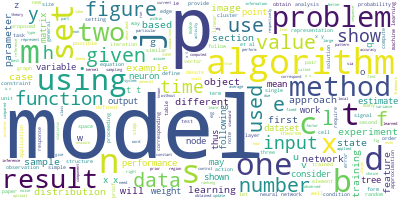

In [9]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(papers['paper_text_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

### **Step 4: Prepare data for LDA analysis**

Now, let’s work to transform the textual data in a format that will serve as an input for training LDA model. We start by tokenizing the text and removing stopwords.

In [10]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]


data = papers.paper_text_processed.values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/elyesaseidel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['sketching', 'structured', 'matrices', 'faster', 'nonlinear', 'regression', 'david', 'woodruff', 'ibm', 'almaden', 'research', 'center', 'san', 'jose', 'ca', 'dpwoodru', 'usibmcom', 'haim', 'avron', 'vikas', 'sindhwani', 'ibm', 'tj', 'watson', 'research', 'center', 'yorktown', 'heights', 'ny', 'haimavvsindhw']


Next, we convert the tokenized object into a corpus and dictionary.

In [11]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 3), (6, 1), (7, 5), (8, 1), (9, 1), (10, 1), (11, 1), (12, 7), (13, 3), (14, 3), (15, 14), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 5), (25, 1), (26, 1), (27, 1), (28, 2), (29, 2)]


### **Step 5: LDA model training**

To keep things simple, we keep all the parameters to default except for inputting the number of topics. We  build a model with 10 topics where each topic is a combination of keywords, and each keyword contributes a certain weightage to the topic.

In [12]:
from pprint import pprint

# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.006*"model" + 0.006*"learning" + 0.006*"algorithm" + 0.005*"data" + '
  '0.004*"set" + 0.004*"time" + 0.004*"number" + 0.004*"one" + 0.003*"problem" '
  '+ 0.003*"used"'),
 (1,
  '0.005*"learning" + 0.005*"model" + 0.004*"data" + 0.004*"set" + '
  '0.004*"function" + 0.004*"using" + 0.004*"time" + 0.003*"input" + '
  '0.003*"two" + 0.003*"one"'),
 (2,
  '0.005*"function" + 0.005*"data" + 0.005*"learning" + 0.004*"set" + '
  '0.004*"algorithm" + 0.004*"model" + 0.003*"two" + 0.003*"time" + '
  '0.003*"using" + 0.003*"number"'),
 (3,
  '0.005*"learning" + 0.005*"model" + 0.004*"algorithm" + 0.004*"time" + '
  '0.004*"using" + 0.004*"data" + 0.004*"models" + 0.003*"one" + '
  '0.003*"figure" + 0.003*"problem"'),
 (4,
  '0.007*"model" + 0.004*"set" + 0.004*"algorithm" + 0.004*"two" + '
  '0.004*"learning" + 0.004*"using" + 0.004*"data" + 0.004*"one" + '
  '0.003*"figure" + 0.003*"based"'),
 (5,
  '0.006*"learning" + 0.006*"model" + 0.005*"set" + 0.004*"data" + '
  '0.004*"time" +

### **Step 6: Analyzing LDA model results**

To visualize the topics for interpretability we use pyLDAvis which is designed to help:

**1. Better understand and interpret individual topics, and**
   
**2. Better understand the relationships between the topics.**

For (1), you can manually select each topic to view its top most frequent and/or “relevant” terms, using different values of the λ parameter. This can help when you’re trying to assign a human interpretable name or “meaning” to each topic.

For (2), exploring the Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.

In [14]:
!pip install pyLDAvis

     |████████████████████████████████| 1.7 MB 5.2 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
    ERROR: Command errored out with exit status 1:
     command: /opt/anaconda3/bin/python -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/sz/80m0v9cn32z4shxrl2t4yj5h0000gn/T/pip-install-l0qfs4gp/sklearn_2ae28e8d23d742389106f409d3044a32/setup.py'"'"'; __file__='"'"'/private/var/folders/sz/80m0v9cn32z4shxrl2t4yj5h0000gn/T/pip-install-l0qfs4gp/sklearn_2ae28e8d23d742389106f409d3044a32/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base /private/var/folders/sz/80m0v9cn32z4shxrl2t4yj5

In [24]:
import warnings
warnings.filterwarnings("ignore") #, category=DeprecationWarning)

In [25]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')

LDAvis_prepared

/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__v

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.002168  0.006220       1        1  19.668116
9      0.006144  0.003640       2        1  13.251576
6     -0.009488  0.001405       3        1  12.979134
0      0.004640  0.001036       4        1  12.550181
1     -0.004879  0.001034       5        1  10.677936
8     -0.003153 -0.009075       6        1   9.586448
3      0.006528  0.000206       7        1   9.095883
2      0.003534 -0.002030       8        1   5.306048
7     -0.003233  0.002455       9        1   5.113040
4      0.002076 -0.004892      10        1   1.771639, topic_info=          Term         Freq        Total Category  logprob  loglift
520      model  1429.000000  1429.000000  Default  30.0000  30.0000
30   algorithm   956.000000   956.000000  Default  29.0000  29.0000
463   learning  1377.000000  1377.000000  Default  28.0000  28.0000
738        set  1014.000000  1014.000000  Default  27.0000  27.0000
861        two   747.000000   747.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
850   training     9.479213   677.943773  Topic10  -6.1119  -0.2367
841       time    10.535937   889.520046  Topic10  -6.0062  -0.4026
627    problem     9.923954   793.197578  Topic10  -6.0661  -0.3479
212  different     7.994566   496.675781  Topic10  -6.2823  -0.0959
555     number     7.972399   660.022720  Topic10  -6.2851  -0.3830

[878 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
5723      1  0.172326  abelian
5723      2  0.114884  abelian
5723      3  0.172326  abelian
5723      4  0.114884  abelian
5723      5  0.172326  abelian
...     ...       ...      ...
911       6  0.070888     zero
911       7  0.078764     zero
911       8  0.047259     zero
911       9  0.047259     zero
911      10  0.015753     zero

[3943 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 10, 7, 1, 2, 9, 4, 3, 8, 5])